In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q efficientnet
!wget 'http://images.cocodataset.org/zips/train2014.zip'
!wget 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
!unzip annotations_trainval2014.zip
!unzip train2014.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: train2014/COCO_train2014_000000408557.jpg  
 extracting: train2014/COCO_train2014_000000013714.jpg  
 extracting: train2014/COCO_train2014_000000194043.jpg  
 extracting: train2014/COCO_train2014_000000219859.jpg  
 extracting: train2014/COCO_train2014_000000278135.jpg  
 extracting: train2014/COCO_train2014_000000141015.jpg  
 extracting: train2014/COCO_train2014_000000280923.jpg  
 extracting: train2014/COCO_train2014_000000200024.jpg  
 extracting: train2014/COCO_train2014_000000435713.jpg  
 extracting: train2014/COCO_train2014_000000249993.jpg  
 extracting: train2014/COCO_train2014_000000424160.jpg  
 extracting: train2014/COCO_train2014_000000142761.jpg  
 extracting: train2014/COCO_train2014_000000532668.jpg  
 extracting: train2014/COCO_train2014_000000564904.jpg  
 extracting: train2014/COCO_train2014_000000346384.jpg  
 extracting: train2014/COCO_train2014_000000560934.jpg  
 extractin

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import efficientnet.tfkeras as efn 

In [ ]:
annotation_file = 'annotations/captions_train2014.json'
PATH = 'train2014/'
!ls {PATH} | wc

  82783   82783 2649056


In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=42)

# Select the first 10000 captions from the shuffled set
num_examples = 10000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

<start> A woman laying on a carpeted floor with a laptop. <end>


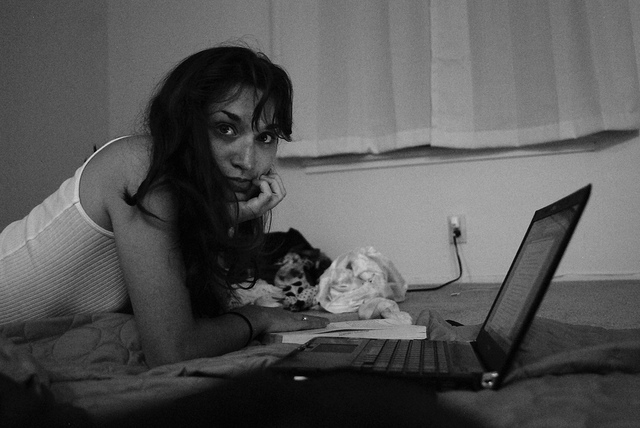

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [ ]:
len(train_captions), len(all_captions)

(10000, 414113)

In [ ]:
target_size = (300, 300,3)
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (target_size[0],target_size[1])) 
    img /= 255
    return img, image_path

In [ ]:
image_model = efn.EfficientNetB3(include_top=False,
                                 weights='noisy-student',
                                 input_shape=target_size)
image_features_extract_model = tf.keras.Model(image_model.input, image_model.layers[-1].output)

43933696/43933088 [==============================] - 1s 0us/step


In [ ]:
image_model.layers[-1], image_model.layers[-1].output.shape

(<tensorflow.python.keras.layers.core.Activation at 0x7f1867b014e0>,
 TensorShape([None, 10, 10, 1536]))

In [ ]:
encode_train = sorted(set(img_name_vector))

feature_dict = {}

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    feature_dict[path_of_feature] = bf.numpy()

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
max_length

45

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=42)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(8000, 8000, 2000, 2000)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 1536
attention_features_shape = bf.shape[0]

In [ ]:
attention_features_shape

100

In [ ]:
def map_func(img_name, cap):
  img_tensor = feature_dict[img_name.decode('utf-8')] # np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
img_name_train[:5]

['train2014/COCO_train2014_000000364956.jpg',
 'train2014/COCO_train2014_000000245682.jpg',
 'train2014/COCO_train2014_000000100395.jpg',
 'train2014/COCO_train2014_000000139237.jpg',
 'train2014/COCO_train2014_000000091118.jpg']

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# No Shuffle for Val and batch
# val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.dropout = tf.keras.layers.Dropout(0.2)
    self.batchnormalization = tf.keras.layers.BatchNormalization()
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.dropout(x)
    x = self.batchnormalization(x)
    x = self.fc2(x)
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead

optimizer = Lookahead(RectifiedAdam(lr=2e-4))
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
@tf.function # Non-teacher-forcing val_loss is too complicated at the moment
def val_step(img_tensor, target, teacher_forcing=True):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
#   print(dec_input.shape) # (BATCH_SIZE, 1)
  features = encoder(img_tensor)
#   print(features.shape) # (BATCH_SIZE, IMG_FEAT_LEN, ENCODER_HID) = 64 100 256
  for i in range(1, target.shape[1]):
    predictions, hidden, _ = decoder(dec_input, features, hidden)
    loss += loss_function(target[:, i], predictions)

    # using teacher forcing
    dec_input = tf.expand_dims(target[:, i], 1)

  avg_loss = (loss / int(target.shape[1]))
  return loss, avg_loss

def cal_val_loss(val_dataset):
  # target.shape = (64,49) = (BATCH_SIZE, SEQ_LEN)
  val_num_steps = len(img_name_val) // BATCH_SIZE

  total_loss = 0
  for (batch, (img_tensor, target)) in enumerate(val_dataset):
    batch_loss, t_loss = val_step(img_tensor, target)
    
    total_loss += t_loss
  print ('Valid Loss {:.6f}'.format(total_loss/val_num_steps))
  return total_loss/val_num_steps

In [ ]:
loss_plot = []
val_loss_plot = []

In [ ]:
len(dataset)

125

In [ ]:
EPOCHS = 20

best_val_loss = 100
for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)   
    val_loss = cal_val_loss(val_dataset)
    val_loss_plot.append(val_loss)
    
    if val_loss < best_val_loss:
      print('update best val loss from %.4f to %.4f' % (best_val_loss, val_loss))
      best_val_loss = val_loss
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1409
Epoch 1 Batch 100 Loss 1.6467
Valid Loss 1.532461
update best val loss from 100.0000 to 1.5325
Epoch 1 Loss 1.952729
Time taken for 1 epoch 93.28760290145874 sec

Epoch 2 Batch 0 Loss 1.4681
Epoch 2 Batch 100 Loss 1.3410
Valid Loss 1.421029
update best val loss from 1.5325 to 1.4210
Epoch 2 Loss 1.403980
Time taken for 1 epoch 34.05940222740173 sec

Epoch 3 Batch 0 Loss 1.4308
Epoch 3 Batch 100 Loss 1.3378
Valid Loss 1.410349
update best val loss from 1.4210 to 1.4103
Epoch 3 Loss 1.373408
Time taken for 1 epoch 34.01804256439209 sec

Epoch 4 Batch 0 Loss 1.3227
Epoch 4 Batch 100 Loss 1.4020
Valid Loss 1.385432
update best val loss from 1.4103 to 1.3854
Epoch 4 Loss 1.353951
Time taken for 1 epoch 34.43532204627991 sec

Epoch 5 Batch 0 Loss 1.3219
Epoch 5 Batch 100 Loss 1.2753
Valid Loss 1.340373
update best val loss from 1.3854 to 1.3404
Epoch 5 Loss 1.312647
Time taken for 1 epoch 34.31537175178528 sec

Epoch 6 Batch 0 Loss 1.3160
Epoch 6 Batch 100 Loss 1.

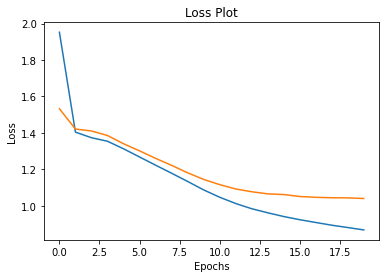

In [ ]:
plt.plot(loss_plot)
plt.plot(val_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
encoder.save_weights('encoder.h5')
decoder.save_weights('decoder.h5')
!ls -sh

total 13G
4.0K annotations		   4.0K drive		  4.5M train2014
242M annotations_trainval2014.zip  1.6M encoder.h5	   13G train2014.zip
4.0K checkpoints		   4.0K sample_data
 24M decoder.h5			   192K tokenizer.pickle


In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    print(img_tensor_val.shape)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    ax = plt.gca()
    img = ax.imshow(temp_image)

    plt.tight_layout()
    plt.show()

(1, 10, 10, 1536)
Real Caption: <start> a baseball player holding a baseball bat inside a stadium <end>
Prediction Caption: a baseball bat <end>


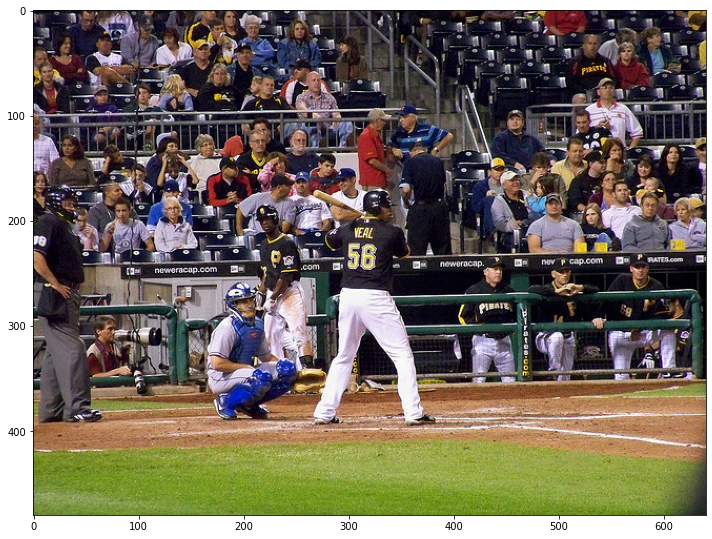

In [ ]:
rid = np.random.randint(0, len(img_name_train))
image = img_name_train[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_train[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)